# Example: Analysis of RISC-V Instruction Traces with MLonMCU

TODO

## Supported components

**Models:** Any (`sine_model` used below)

**Frontends:** Any (`tflite` used below)

**Frameworks/Backends:** Any (`tvmaotplus` used below)

**Platforms/Targets:** `etiss_pulpino`, `spike`, `ovpsim` (`etiss_pulpino` used below)

## Prerequisites

Set up MLonmCU as usual, i.e. initializa an environment and install all required dependencies. Feel free to use the following minimal `environment.yml.j2` template:

```yaml
---
home: "{{ home_dir }}"
logging:
  level: DEBUG
  to_file: false
  rotate: false
cleanup:
  auto: true
  keep: 10
paths:
  deps: deps
  logs: logs
  results: results
  plugins: plugins
  temp: temp
  models:
    - "{{ home_dir }}/models"
    - "{{ config_dir }}/models"
repos:
  tvm:
    url: "https://github.com/apache/tvm.git"
    ref: de6d8067754d746d88262c530b5241b5577b9aae
  etiss:
    url: "https://github.com/tum-ei-eda/etiss.git"
    ref: 4d2d26fb1fdb17e1da3a397c35d6f8877bf3ceab
  mlif:
    url: "https://github.com/tum-ei-eda/mlonmcu-sw.git"
    ref: 4b9a32659f7c5340e8de26a0b8c4135ca67d64ac
frameworks:
  default: tvm
  tvm:
    enabled: true
    backends:
      default: tvmaotplus
      tvmaotplus:
        enabled: true
        features: []
    features: []
frontends:
  tflite:
    enabled: true
    features: []
toolchains:
  gcc: true
platforms:
  mlif:
    enabled: true
    features: []
targets:
  default: etiss_pulpino
  etiss_pulpino:
    enabled: true
    features:
      log_instrs: true
```

Do not forget to set your `MLONMCU_HOME` environment variable first if not using the default location!

## Usage

### A) Command Line Interface

Add the following arguments to your command:

`--feature log_instrs --config log_instrs.to_file=1 --postprocess analyse_instructions`

**Example:**

In [1]:
!mlonmcu flow run sine_model --backend tvmaotplus --target etiss_pulpino --feature log_instrs --config log_instrs.to_file=1 --postprocess analyse_instructions

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-240]  Processing stage LOAD
INFO - [session-240]  Processing stage BUILD
INFO - [session-240]  Processing stage COMPILE
INFO - [session-240]  Processing stage RUN
WARNING - unexpected script output (cycles)
INFO - [session-240]  Processing stage POSTPROCESS
ERROR - 'builtin_function_or_method' object is not subscriptable
Traceback (most recent call last):
  File "/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/lib/python3.8/site-packages/mlonmcu-0.3.0.dev0-py3.8.egg/mlonmcu/session/run.py", line 782, in process
    func()
  File "/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/lib/python3.8/site-packages/mlonmcu-0.3.0.dev0-py3.8.egg/mlonmcu/session/run.py", line 549, in postprocess
    artifacts = postprocess.post_run(temp_report, self.artifacts)
  File "/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/lib/python3.8/site-packages/mlonmcu-0.3.0.dev0-py3.8.egg/mlonmcu/session/run.py", li

### B) Python Scripting

Python Imports

In [3]:
from tempfile import TemporaryDirectory
from pathlib import Path
import pandas as pd

from mlonmcu.context.context import MlonMcuContext
from mlonmcu.session.run import RunStage

Benchmark Configuration

In [4]:
FRONTEND = "tflite"
MODEL = "sine_model"
BACKEND = "tvmaotplus"
PLATFORM = "mlif"
TARGET = "etiss_pulpino"
FEATURES = ["log_instrs"]
CONFIG = {"log_instrs.to_file": True}
POSTPROCESSES = ["analyse_instructions"]

Initialize and run a single benchmark

In [5]:
with MlonMcuContext() as context:
    session = context.create_session()
    run = session.create_run(config=CONFIG)
    run.add_features_by_name(FEATURES, context=context)
    run.add_frontend_by_name(FRONTEND, context=context)
    run.add_model_by_name(MODEL, context=context)
    run.add_backend_by_name(BACKEND, context=context)
    run.add_platform_by_name(PLATFORM, context=context)
    run.add_target_by_name(TARGET, context=context)
    run.add_postprocesses_by_name(POSTPROCESSES)
    session.process_runs(context=context)
    report = session.get_reports()
report.df

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-241] Processing all stages
WARNING - unexpected script output (cycles)
ERROR - 'builtin_function_or_method' object is not subscriptable
Traceback (most recent call last):
  File "/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/lib/python3.8/site-packages/mlonmcu-0.3.0.dev0-py3.8.egg/mlonmcu/session/run.py", line 782, in process
    func()
  File "/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/lib/python3.8/site-packages/mlonmcu-0.3.0.dev0-py3.8.egg/mlonmcu/session/run.py", line 549, in postprocess
    artifacts = postprocess.post_run(temp_report, self.artifacts)
  File "/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/lib/python3.8/site-packages/mlonmcu-0.3.0.dev0-py3.8.egg/mlonmcu/session/run.py", line 507, in artifacts
    itertools.chain([subs[subs.keys[0]] for stage, subs in self.artifacts_per_stage.items()])
  File "/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/lib/python3.8/site-package

,Session,Run,Model,Frontend,Framework,Backend,Platform,Target,Total ROM,Total RAM,ROM read-only,ROM code,ROM misc,RAM data,RAM zero-init data,Features,Config,Postprocesses,Comment,Failing
0,241,0,sine_model,tflite,tvm,tvmaotplus,mlif,etiss_pulpino,56100,2737,4280,51676,144,2493,244,[log_instrs],"{'tflite.use_inout_data': False, 'tflite.visua...",[analyse_instructions],-,True


The report is available as pandas dataframe.

Let's extract the artifacts created by the `analyse_instructions` postprocess:

In [6]:
artifacts = session.runs[0].artifacts_per_stage[RunStage.POSTPROCESS]["default"]

TypeError: list indices must be integers or slices, not str

**Visualization of used Instruction types**

In [7]:
with TemporaryDirectory() as tmpdirname:
    dest = Path(tmpdirname) / "analyse_instructions_majors.csv"
    artifacts[0].export(dest)
    majors_df = pd.read_csv(dest)
    majors_df = majors_df.drop("Probablity", axis=1)
    majors_df.plot.bar(x="Major", title=f"Top Major Opcodes")

NameError: name 'artifacts' is not defined

**Most used (groups of) intructions in the program**

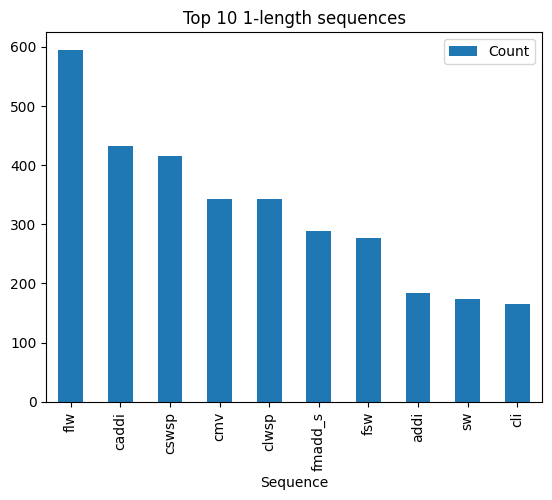

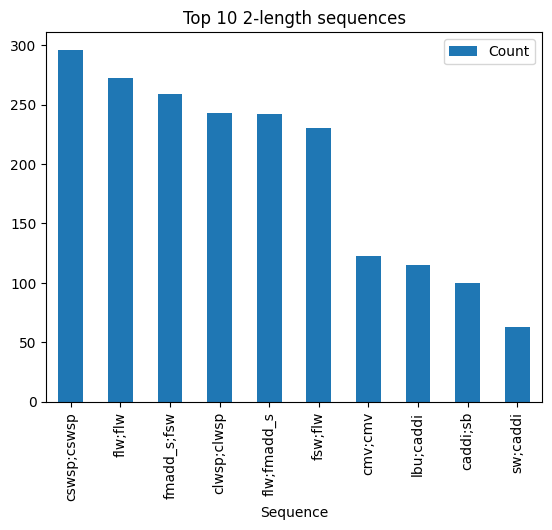

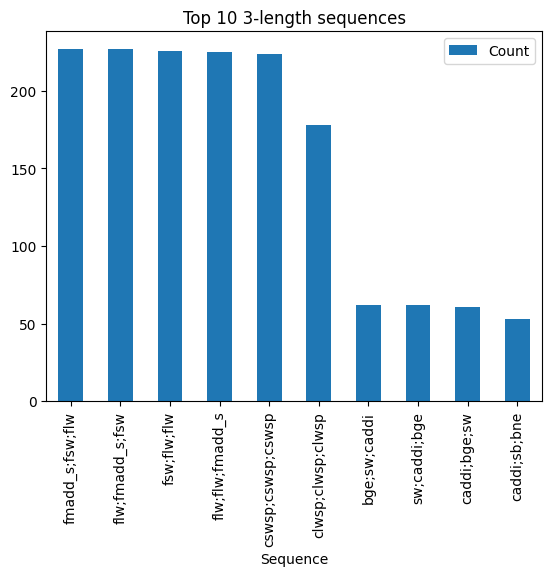

In [6]:
with TemporaryDirectory() as tmpdirname:
    for i in range(1, 4):
        dest = Path(tmpdirname) / f"analyse_instructions_seq{i}.csv"
        artifacts[i].export(dest)
        seq_df = pd.read_csv(dest)
        top = len(seq_df)
        seq_df = seq_df.drop("Probablity", axis=1)
        seq_df.plot.bar(x="Sequence", title=f"Top {top} {i}-length sequences")